In [15]:
import torch
from pathlib import Path
import numpy as np
import scipy
#from skimage import io
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
root_dir = Path.cwd().parent
data_dir = root_dir / 'data'
model_dir = root_dir / 'models'

root_dir
data_dir

PosixPath('/Users/juan/Documents/DTU/2 Semester MSc/Perception for AS/Project/PFAS---final-project/data')

In [17]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_dir / 'best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /Users/juan/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-5-5 Python-3.11.2 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients
Adding AutoShape... 


requirements: /Users/juan/.cache/torch/hub/requirements.txt not found, check failed.


In [5]:
model.eval();

In [18]:
img_left_path = data_dir / "raw/final_project_2023_rect/seq_03/image_02/data/0000000005.png"  # or file, Path, PIL, OpenCV, numpy, list
img_right_path = data_dir / "raw/final_project_2023_rect/seq_03/image_03/data/0000000005.png"  # or file, Path, PIL, OpenCV, numpy, list

img_left = cv2.imread(str(img_left_path))
img_right = cv2.imread(str(img_right_path))


# Inference
results = model([img_left, img_right])

# Results
r = results.pandas().xyxy

results_left_df = r[0]
results_right_df = r[1]

In [19]:
results_left_df.head()

,xmin,ymin,xmax,ymax,confidence,class,name
0,0.000000,201.514206,297.433044,370.000000,0.978220,0,Car
1,1000.916809,151.643967,1076.956909,295.646484,0.933369,1,Pedestrian
2,446.264679,172.997131,483.641022,198.633377,0.927031,0,Car
3,867.967468,167.970062,917.901184,276.058960,0.835764,0,Car


In [20]:
results_right_df.head()

,xmin,ymin,xmax,ymax,confidence,class,name
0,788.372253,153.427689,893.130249,277.143463,0.953341,2,Cyclist
1,0.000000,195.325424,233.257751,367.463257,0.950212,0,Car
2,438.047150,173.084259,475.409637,199.053818,0.943545,0,Car
3,958.674683,145.034409,1032.881836,297.623169,0.904521,1,Pedestrian


In [22]:
def match_objects(
    results_left_df: pd.DataFrame,
    results_right_df: pd.DataFrame,
    img_left_path: Path,
    img_right_path: Path,
) -> pd.DataFrame:
    """Match objects from left and right images.

    Args:
        results_left_df (pd.DataFrame): Results from left image.
        results_right_df (pd.DataFrame): Results from right image.
        calib_file (str): Path to calibration file.

    Returns:
        pd.DataFrame: Matched objects.
    """

    # read images and convert to gray
    img_left = cv2.imread(str(img_left_path))
    img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)
    img_right = cv2.imread(str(img_right_path))
    img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    
    nb_matches = 20
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher()
    im_height = img_left.shape[0]
    match_matrix = np.zeros((len(results_left_df.index), len(results_right_df.index)))
    for i1, bbox1 in results_left_df.iterrows():
        for i2, bbox2 in results_right_df.iterrows():
            cy1 = bbox1["ymin"] + bbox1["ymax"] / 2
            cy2 = bbox2["ymin"] + bbox2["ymax"] / 2
            if abs(cy1 - cy2) / im_height <= 0.1 and bbox1[5] == bbox2[5]:
                bbox1_im = img_left_gray[
                    int(bbox1["ymin"]) : int(bbox1["ymax"]),
                    int(bbox1["xmin"]) : int(bbox1["xmax"]),
                ]
                bbox2_im = img_right_gray[
                    int(bbox2["ymin"]) : int(bbox2["ymax"]),
                    int(bbox2["xmin"]) : int(bbox2["xmax"]),
                ]
                kp1, des1 = sift.detectAndCompute(bbox1_im, None)
                kp2, des2 = sift.detectAndCompute(bbox2_im, None)
                matches = bf.match(des1, des2)
                matches = sorted(matches, key=lambda x: x.distance)[:nb_matches]
                for m in matches:
                    match_matrix[i1, i2] += m.distance
            else:
                match_matrix[i1, i2] = 1e12
    print(match_matrix.shape)
    print(match_matrix)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(match_matrix)

    return row_ind, col_ind

In [23]:
row_ind, col_ind = match_objects(
    r[0],
    r[1],
    img_left_path,
    img_right_path,
)

(4, 4)
[[      1e+12      2785.2       1e+12       1e+12]
 [      1e+12       1e+12       1e+12      2269.9]
 [      1e+12       1e+12      4028.3       1e+12]
 [      1e+12       1e+12      7780.8       1e+12]]


In [24]:
results_right_df

img_right = cv2.imread(str(img_right_path))

random_color = tuple(int(color) for color in np.random.choice(range(255),size=3))

box2 = results_right_df.iloc[2]
x_min = int(box2["xmin"])
y_min = int(box2["ymin"])
x_max = int(box2["xmax"])
y_max = int(box2["ymax"])
#cv2.rectangle(img_right, (x_min, y_min), (x_max, y_max), random_color, 2)
#plt.imshow(img_right)
#plt.show()

In [12]:
print(col_ind, row_ind)

[1 3 2 0] [0 1 2 3]


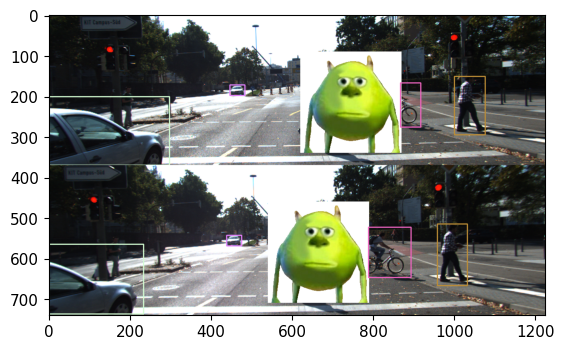

In [27]:
img_left = cv2.imread(str(img_left_path))
img_right = cv2.imread(str(img_right_path))

for i1,i2 in zip(row_ind, col_ind):
    # draw on left image
    random_color = tuple(int(color) for color in np.random.choice(range(255),size=3))
    box1 = results_left_df.iloc[i1]
    x_min = int(box1["xmin"])
    y_min = int(box1["ymin"])
    x_max = int(box1["xmax"])
    y_max = int(box1["ymax"])
    cv2.rectangle(img_left, (x_min, y_min), (x_max, y_max), random_color, 2)

    # draw on right image
    box2 = results_right_df.iloc[i2]
    x_min = int(box2["xmin"])
    y_min = int(box2["ymin"])
    x_max = int(box2["xmax"])
    y_max = int(box2["ymax"])
    cv2.rectangle(img_right, (x_min, y_min), (x_max, y_max), random_color, 2)
merged = np.concatenate((img_left, img_right), axis=0)

# cv change colorspace of merged from bgr to rgb
merged_show = cv2.cvtColor(merged, cv2.COLOR_BGR2RGB)
plt.imshow(merged_show)
plt.show()
# cv2.imshow('im', merged)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [14]:
min_disp = 3
num_disp = 5 * 16
block_size = 31
stereo = cv2.StereoBM_create(numDisparities = num_disp, blockSize = block_size)
stereo.setMinDisparity(min_disp)
stereo.setDisp12MaxDiff(200)
stereo.setUniquenessRatio(1)
stereo.setSpeckleRange(3)
stereo.setSpeckleWindowSize(3)

im_left_gray = cv2.cvtColor(im_left, cv2.COLOR_RGB2GRAY)
im_right_gray = cv2.cvtColor(im_right, cv2.COLOR_RGB2GRAY)
disp = stereo.compute(im_left_gray, im_right_gray).astype(np.float32) / 16.0

plt.figure(figsize=(18,18))
plt.imshow(disp)

NameError: name 'im_left' is not defined